In [21]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

Data Analysis

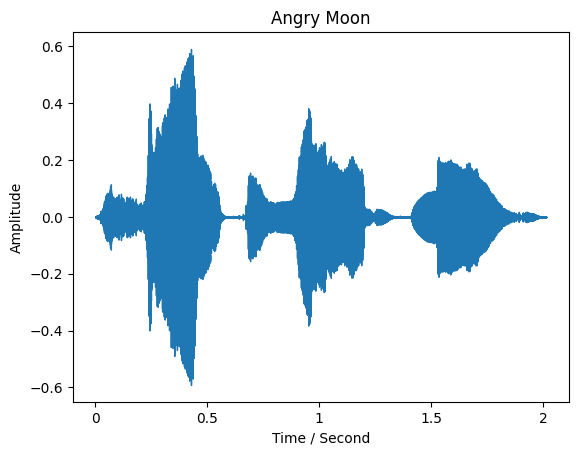

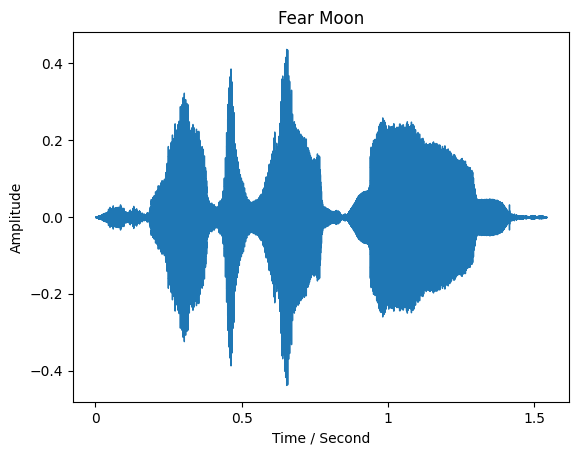

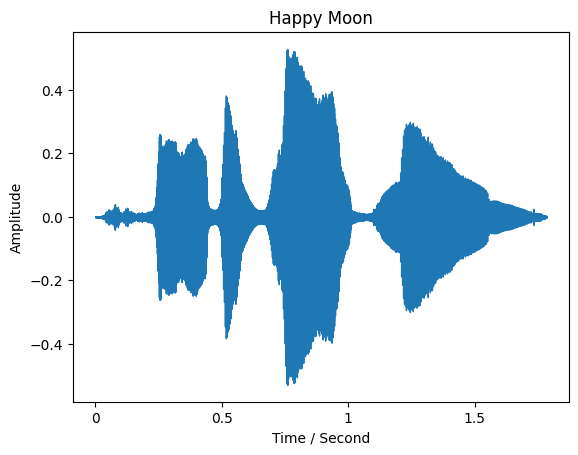

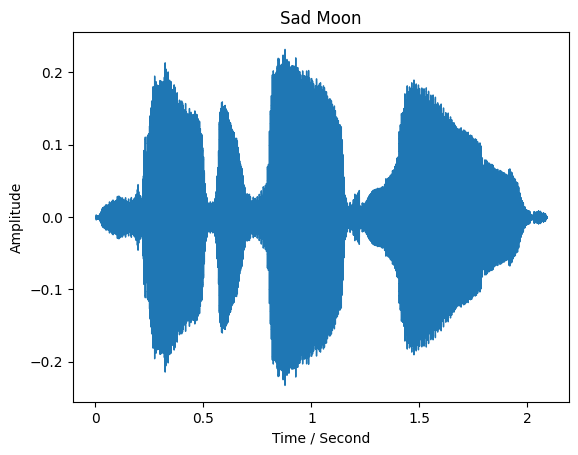

In [22]:
# plot all the moon ones as time and frequency 

signal_angry, sample_rate_angry = librosa.load("./data_folder/angry/YAF_moon_angry.wav")
signal_fear, sample_rate_fear = librosa.load("./data_folder/fear/YAF_moon_fear.wav")
signal_happy, sample_rate_happy = librosa.load("./data_folder/happy/YAF_moon_happy.wav")
signal_sad, sample_rate_sad = librosa.load("./data_folder/sad/YAF_moon_sad.wav")

# angry
plt.figure(1)
librosa.display.waveshow(y=signal_angry, sr=sample_rate_angry)
plt.xlabel('Time / Second')
plt.ylabel('Amplitude')
plt.title("Angry Moon")
plt.show()
# fear
plt.figure(2)
librosa.display.waveshow(y=signal_fear, sr=sample_rate_fear)
plt.xlabel('Time / Second')
plt.ylabel('Amplitude')
plt.title("Fear Moon")
plt.show()
# happy
plt.figure(3)
librosa.display.waveshow(y=signal_happy, sr=sample_rate_happy)
plt.xlabel('Time / Second')
plt.ylabel('Amplitude')
plt.title("Happy Moon")
plt.show()
# sad
plt.figure(4)
librosa.display.waveshow(y=signal_sad, sr=sample_rate_sad)
plt.xlabel('Time / Second')
plt.ylabel('Amplitude')
plt.title("Sad Moon")
plt.show()



In [23]:
# train and test

import os
import random
import shutil


data_dir = './data_folder'
training_dir = './Training Data'
test_dir = './Test Data'



train_list = []
test_lis = []
# Loop through each folder in the data directory
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    file_names = os.listdir(folder_path)
    random.shuffle(file_names)
    
    training_set = file_names[:70]
    test_set = file_names[70:]
    
    for file_name in training_set:
        train_list.append({'file name': file_name, 'label': folder_name})
    for file_name in test_set:
        test_lis.append({'file name': file_name, 'label': folder_name})
    
    os.makedirs(os.path.join(training_dir, folder_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, folder_name), exist_ok=True)
    
    for file_name in training_set:
        source_path = os.path.join(folder_path, file_name)
        destination_path = os.path.join(training_dir, folder_name, file_name)
        shutil.copyfile(source_path, destination_path)

    for file_name in test_set:
        source_path = os.path.join(folder_path, file_name)
        destination_path = os.path.join(test_dir, folder_name, file_name)
        shutil.copyfile(source_path, destination_path)


train = pd.DataFrame(train_list, columns=['file name', 'label'])
test = pd.DataFrame(test_lis, columns=['file name', 'label'])


Acoustic Feature Extraction Methods

In [24]:
# based on sample code provided

# loudness
def loudness(loudness_signal):
    df_loudness = pd.DataFrame()
    S, phase = librosa.magphase(librosa.stft(loudness_signal))
    rms = librosa.feature.rms(S=S)
    df_loudness['Loudness'] = rms[0]
    return df_loudness

# mel-frequency cepstral
def mel_freq(mel_freq_signal, mel_freq_sr):
    mfccs = np.mean(librosa.feature.mfcc(y=mel_freq_signal, sr=mel_freq_sr, n_mfcc=12).T, axis = 0)
    return mfccs

# zero crossing
def zero_crossing(zero_crossing_signal):
    df_zero_crossing_rate = pd.DataFrame()
    zcr = librosa.feature.zero_crossing_rate(y=zero_crossing_signal)
    df_zero_crossing_rate['ZCR'] = zcr[0]
    return df_zero_crossing_rate

# chroma
def chroma(chroma_signal, chroma_sr):
    chromagram = np.mean(librosa.feature.chroma_stft(y=chroma_signal, sr=chroma_sr).T, axis = 0)
    return chromagram

# mel spectrogram
def mel_spectrogram(mel_spect_signal, mel_spect_sr):
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=mel_spect_signal, sr=mel_spect_sr, n_mels=12).T, axis=0)
    return mel_spectrogram


Feature Extraction

In [25]:
# go through all in train 

training_features = []
training_labels = []
for folder_name in os.listdir("./Training Data/"):
    for file in os.listdir("./Training Data/" + folder_name):
        signal, rate = librosa.load("./Training Data/" + folder_name + "/" + file)
        matrix = np.array([])
        matrix = np.hstack((matrix, np.mean(loudness(signal).dropna().to_numpy())))
        matrix = np.hstack((matrix, mel_freq(signal, rate)))
        matrix = np.hstack((matrix, np.mean(zero_crossing(signal).dropna().to_numpy())))
        matrix = np.hstack((matrix, chroma(signal, rate)))
        matrix = np.hstack((matrix, mel_spectrogram(signal, rate)))
        training_labels.append(folder_name)
        training_features.append(matrix)
    
    

#go through all in test
testing_features = []
testing_labels = []
for folder_name in os.listdir("./Test Data/"):
    for file in os.listdir("./Test Data/" + folder_name):
        signal, rate = librosa.load("./Test Data/" + folder_name + "/" + file)
        matrix = np.array([])
        matrix = np.hstack((matrix, np.mean(loudness(signal).dropna().to_numpy())))
        matrix = np.hstack((matrix, mel_freq(signal, rate)))
        matrix = np.hstack((matrix, np.mean(zero_crossing(signal).dropna().to_numpy())))
        matrix = np.hstack((matrix, chroma(signal, rate)))
        matrix = np.hstack((matrix, mel_spectrogram(signal, rate)))
        testing_labels.append(folder_name)
        testing_features.append(matrix)

# scaling
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
labels = LabelEncoder()
x_train = scaler.fit_transform(training_features)
x_test = scaler.transform(testing_features)

labels.fit(train['label'])
y_train = labels.transform(train['label'])
y_test = labels.transform(test['label'])

Model Building

In [26]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

gauss = GaussianNB()
randomForest = RandomForestClassifier()
svc = svm.SVC(kernel='rbf', probability=True)

gauss.fit(x_train, y_train)
randomForest.fit(x_train, y_train)
svc.fit(x_train, y_train)





SVC(probability=True)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.97      0.98        30
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        30

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        30
           1       0.94      0.97      0.95        30
           2       1.00      0.93      0.97        30
           3       1.00      0.97      0.98        30

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.

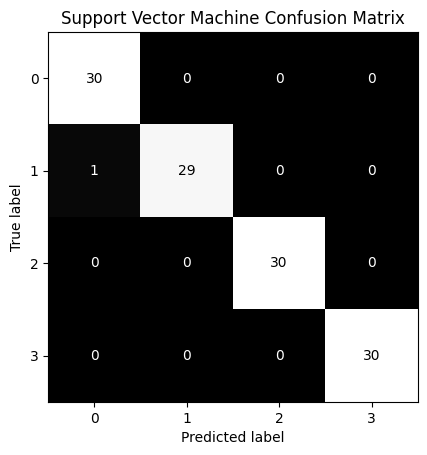

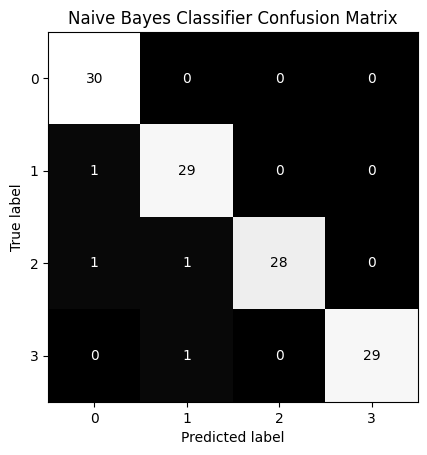

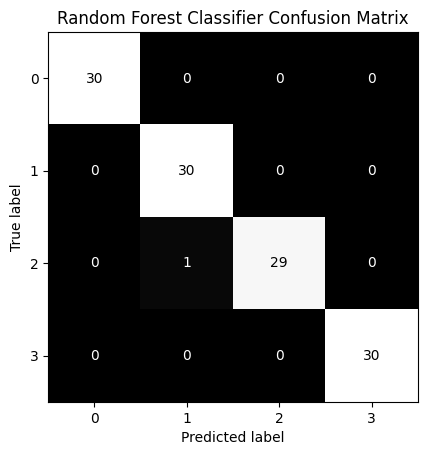

In [27]:
y_svc_predicted = svc.predict(x_test)
y_svc_pred_proba = svc.predict_proba(x_test)

y_gauss_predicted = gauss.predict(x_test)
y_gauss_pred_proba = gauss.predict_proba(x_test)

y_randomForest_predicted = randomForest.predict(x_test)
y_randomForest_pred_proba = randomForest.predict_proba(x_test)


print(classification_report(y_test, y_svc_predicted))
print(classification_report(y_test, y_gauss_predicted))
print(classification_report(y_test, y_randomForest_predicted))


models = ['Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions = [y_svc_predicted, y_gauss_predicted, y_randomForest_predicted]
pred_probabilities = [y_svc_pred_proba, y_gauss_pred_proba, y_randomForest_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")


Without Loudness or Zero Crossing

In [28]:

training_features_second = []
training_labels_second = []
for folder_name in os.listdir("./Training Data/"):
    for file in os.listdir("./Training Data/" + folder_name):
        signal, rate = librosa.load("./Training Data/" + folder_name + "/" + file)
        matrix = np.array([])
        matrix = np.hstack((matrix, mel_freq(signal, rate)))
        matrix = np.hstack((matrix, chroma(signal, rate)))
        matrix = np.hstack((matrix, mel_spectrogram(signal, rate)))
        training_labels_second.append(folder_name)
        training_features_second.append(matrix)
    
    

#go through all in test
testing_features_second = []
testing_labels_second = []
for folder_name in os.listdir("./Test Data/"):
    for file in os.listdir("./Test Data/" + folder_name):
        signal, rate = librosa.load("./Test Data/" + folder_name + "/" + file)
        matrix = np.array([])
        matrix = np.hstack((matrix, mel_freq(signal, rate)))
        matrix = np.hstack((matrix, chroma(signal, rate)))
        matrix = np.hstack((matrix, mel_spectrogram(signal, rate)))
        testing_labels_second.append(folder_name)
        testing_features_second.append(matrix)


x_train_second = scaler.fit_transform(training_features_second)
x_test_second = scaler.transform(testing_features_second)

labels.fit(train['label'])
y_train_second = labels.transform(train['label'])
y_test_second = labels.transform(test['label'])

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.97      0.98        30
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        30

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        30
           1       0.94      0.97      0.95        30
           2       1.00      0.93      0.97        30
           3       1.00      0.97      0.98        30

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.

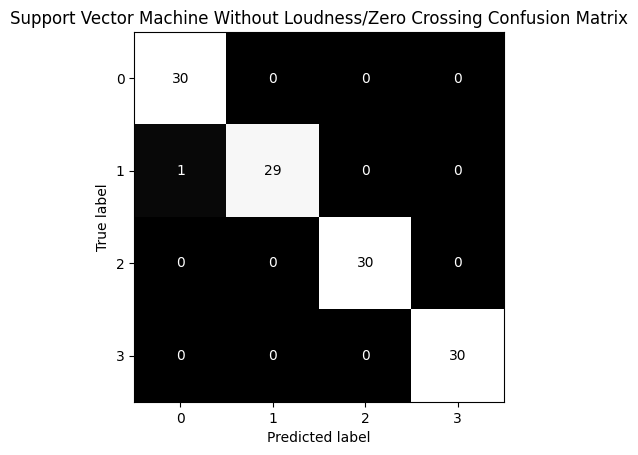

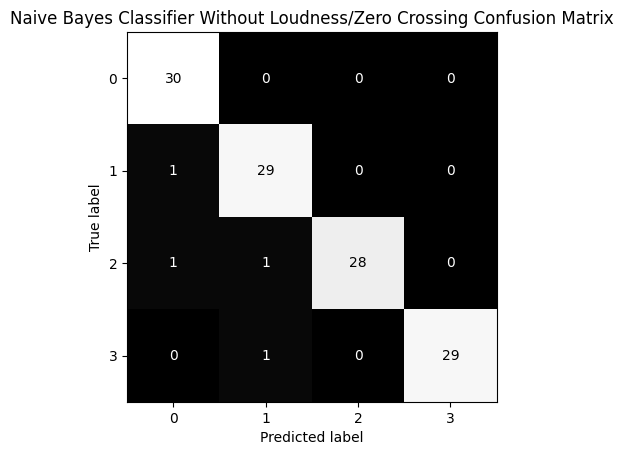

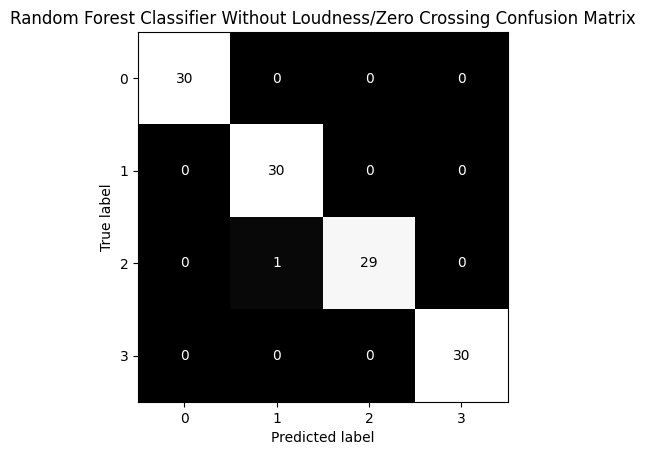

In [29]:
gauss_second = GaussianNB()
randomForest_second = RandomForestClassifier()
svc_second = svm.SVC(kernel='rbf', probability=True)

gauss_second.fit(x_train_second, y_train_second)
randomForest_second.fit(x_train_second, y_train_second)
svc_second.fit(x_train_second, y_train_second)


y_svc_predicted_second = svc_second.predict(x_test_second)
y_svc_pred_proba_second = svc_second.predict_proba(x_test_second)

y_gauss_predicted_second = gauss_second.predict(x_test_second)
y_gauss_pred_proba_second = gauss_second.predict_proba(x_test_second)

y_randomForest_predicted_second = randomForest_second.predict(x_test_second)
y_randomForest_pred_proba_second = randomForest_second.predict_proba(x_test_second)


print(classification_report(y_test_second, y_svc_predicted_second))
print(classification_report(y_test_second, y_gauss_predicted_second))
print(classification_report(y_test_second, y_randomForest_predicted_second))


models = ['Support Vector Machine Without Loudness/Zero Crossing', 'Naive Bayes Classifier Without Loudness/Zero Crossing', 'Random Forest Classifier Without Loudness/Zero Crossing']
predictions = [y_svc_predicted_second, y_gauss_predicted_second, y_randomForest_predicted_second]
pred_probabilities = [y_svc_pred_proba_second, y_gauss_pred_proba_second, y_randomForest_pred_proba_second]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")
